In [2]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip

%matplotlib inline

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img,
                                  orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis,
                                  feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img,
                       orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis,
                       feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    hist_list = [];
    for channel in range(img.shape[2]):
        hist = np.histogram(img[:,:,channel], bins=nbins, range=bins_range)
        hist_list.append(hist[0])

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate(hist_list)
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def convert_color(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'GRAY':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            feature_image = np.reshape(feature_image, (img.shape[0], img.shape[1], 1))
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    return feature_image

# Extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img,
                        color_space='RGB',
                        spatial_size=(32, 32),
                        hist_bins=32,
                        orient=9, 
                        pix_per_cell=8,
                        cell_per_block=2,
                        hog_channel=0,
                        spatial_feat=True,
                        hist_feat=True,
                        hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color(img, color_space)
  
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                                     orient,
                                                     pix_per_cell,
                                                     cell_per_block,
                                                     vis=False,
                                                     feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        img_features = single_img_features(mpimg.imread(file),
                                          color_space,
                                          spatial_size,
                                          hist_bins,
                                          orient,
                                          pix_per_cell,
                                          cell_per_block,
                                          hog_channel,
                                          spatial_feat,
                                          hist_feat,
                                          hog_feat)

        features.append(img_features)
    # Return list of feature vectors
    return features



In [4]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img,
                   windows,
                   clf,
                   scaler,
                   color_space='RGB',
                   spatial_size=(32, 32),
                   hist_bins=32,
                   hist_range=(0, 256),
                   orient=9, 
                   pix_per_cell=8,
                   cell_per_block=2, 
                   hog_channel=0,
                   spatial_feat=True, 
                   hist_feat=True,
                   hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img,
                                       color_space=color_space, 
                                       spatial_size=spatial_size,
                                       hist_bins=hist_bins,
                                       orient=orient,
                                       pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel,
                                       spatial_feat=spatial_feat,
                                       hist_feat=hist_feat,
                                       hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img,
                 x_start_stop=[None, None],
                 y_start_stop=[None, None], 
                 xy_window=(64, 64),
                 xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

8792 8968


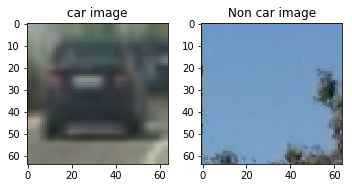

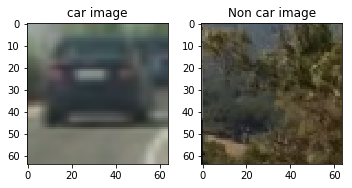

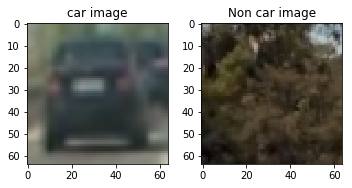

In [5]:
# Read in cars and notcars
cars = []
notcars = []
for image in glob.glob('train_data/full/vehicles/**/*.png'):
    cars.append(image)
    
for image in glob.glob('train_data/full/non-vehicles/**/*.png'):
    notcars.append(image)

print(len(cars), len(notcars))


for i in range(0,3):
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1,2,1)
    plt.imshow(mpimg.imread(cars[i]))
    plt.title('car image')
    plt.subplot(1,2,2)
    plt.imshow(mpimg.imread(notcars[i]))
    plt.title('Non car image')
    fig.tight_layout()
plt.show()

In [6]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 18  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [7]:
import time

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
print(round(t - t2, 2), 'Seconds to predict test SVC...')

Using: 18 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 11448
5.25 Seconds to train SVC...
Test Accuracy of SVC =  0.993
0.07 Seconds to predict test SVC...


5


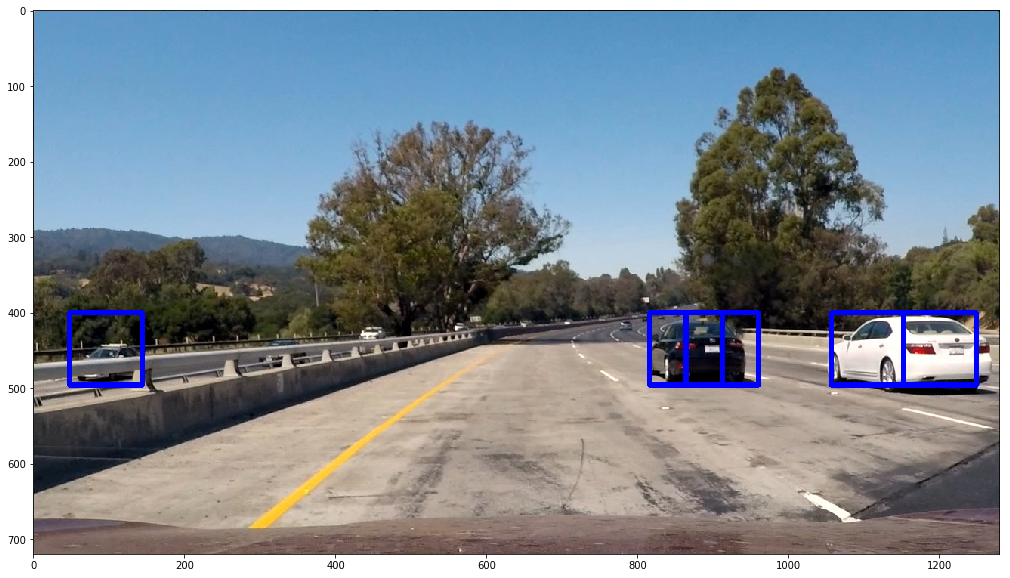

In [8]:
image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32) / 255

windows = slide_window(image,
                       x_start_stop=[None, None],
                       y_start_stop=[400, None], 
                       xy_window=(96, 96),
                       xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image,
                             windows,
                             svc,
                             X_scaler,
                             color_space=color_space,
                             spatial_size=spatial_size,
                             hist_bins=hist_bins,
                             orient=orient,
                             pix_per_cell=pix_per_cell,
                             cell_per_block=cell_per_block,
                             hog_channel=hog_channel,
                             spatial_feat=spatial_feat,
                             hist_feat=hist_feat,
                             hog_feat=hog_feat)                       

print(len(hot_windows))
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.figure(figsize=(20,10))
plt.imshow(window_img)

In [24]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_bboxes(img,
                     ystart,
                     ystop,
                     scale,
                     svc,
                     X_scaler,
                     orient,
                     pix_per_cell,
                     cell_per_block,
                     cells_per_step,
                     spatial_size,
                     hist_bins,
                     color_space='RGB',
                     spatial_feat=True,
                     hist_feat=True,
                     hog_feat=True,
                     debug=False):
    img = img.astype(np.float32) / 255
    bboxes = []
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space)

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    if len(ctrans_tosearch.shape) == 2:
        ctrans_tosearch = np.reshape(ctrans_tosearch, ctrans_tosearch.shape + (1,))

    ch1 = ctrans_tosearch[:,:,0]
    if ctrans_tosearch.shape[2] > 1:
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if ctrans_tosearch.shape[2] > 1:
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)


    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if ctrans_tosearch.shape[2] > 1:
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_features, hog_feat2, hog_feat3))

            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            if hist_feat:
                hist_features = color_hist(subimg, nbins=hist_bins)
                hog_features = np.hstack((hist_features, hog_features))

            # Get color features
            if spatial_feat:
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hog_features = np.hstack((spatial_features, hog_features))
                


            # Scale features and make a prediction
            test_features = X_scaler.transform(hog_features.reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1 or debug == True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                
    return bboxes

def find_cars_debug(img,
                    ystart,
                    ystop,
                    scale,
                    cells_per_step):
    bboxes = find_cars_bboxes(img,
                              ystart,
                              ystop,
                              scale,
                              svc, X_scaler,
                              orient, pix_per_cell,
                              cell_per_block, cells_per_step,
                              spatial_size, hist_bins,
                              "RGB", True,
                              True, True, True)
    draw_img = draw_boxes(img, bboxes)

    return draw_img

### Find appropriate parameters for find_cars_bboxes function
Try different ystart, ystop, scale and cells_per_step parameters and ones which looks reasonably good.

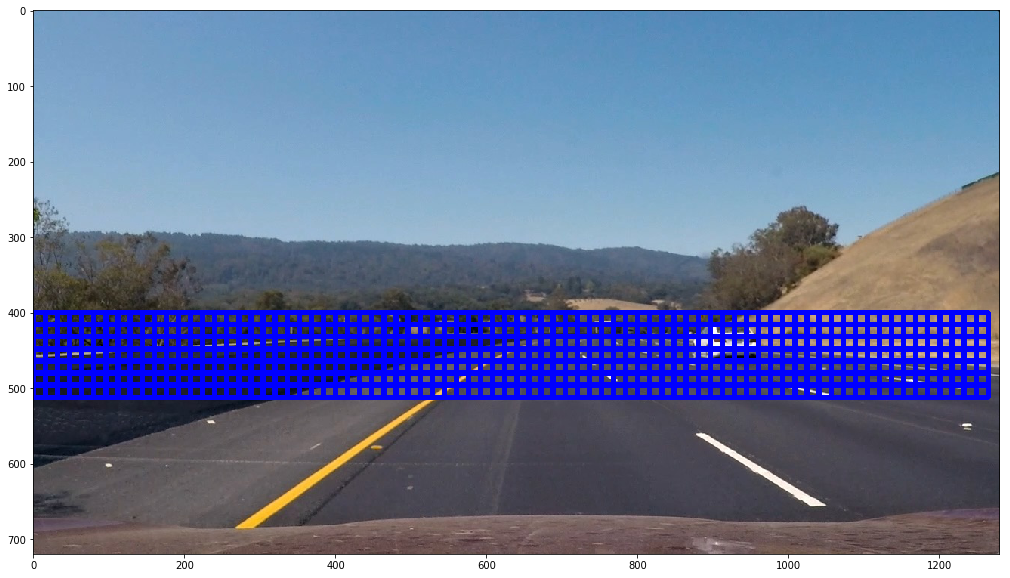

In [26]:
img = mpimg.imread('test_images/test3.jpg')
out_img = find_cars_debug(img,
                          ystart=400,
                          ystop=530,
                          scale=1,
                          cells_per_step=2)
plt.figure(figsize=(20,10))
plt.imshow(out_img)

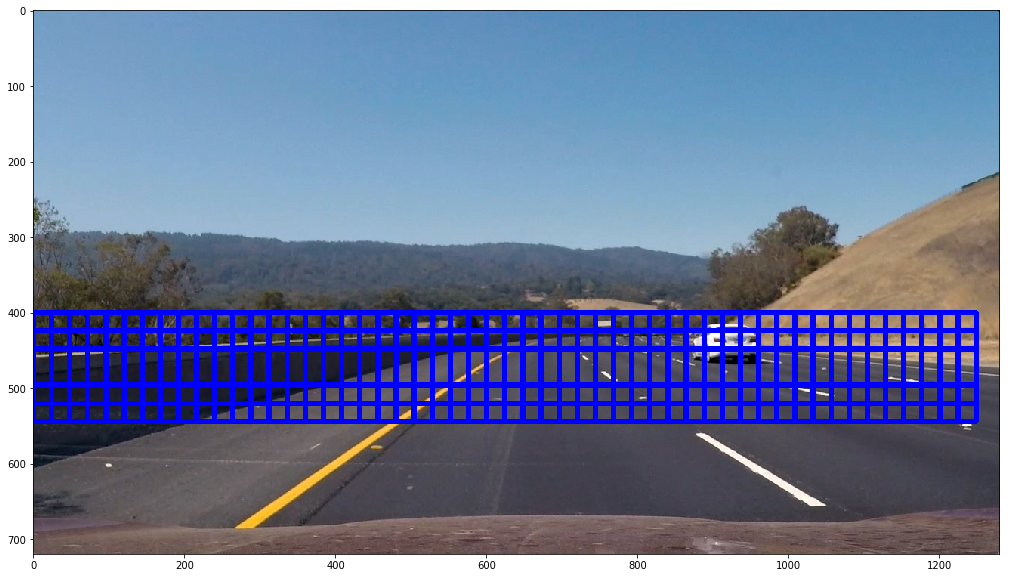

In [30]:
img = mpimg.imread('test_images/test3.jpg')
out_img = find_cars_debug(img,
                          ystart=400,
                          ystop=570,
                          scale=1.5,
                          cells_per_step=2)
plt.figure(figsize=(20,10))
plt.imshow(out_img)

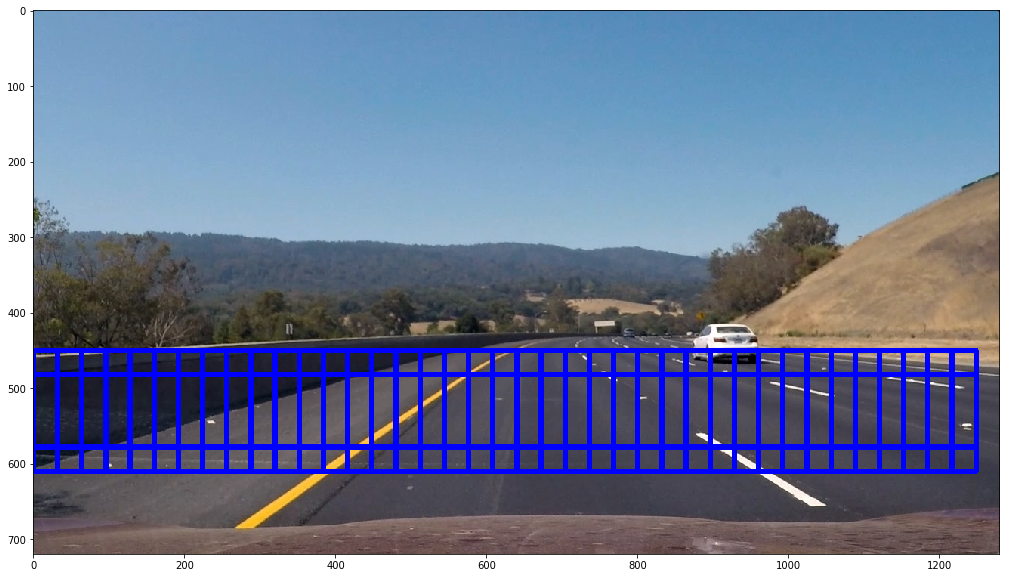

In [31]:
img = mpimg.imread('test_images/test3.jpg')
out_img = find_cars_debug(img,
                          ystart=450,
                          ystop=650,
                          scale=2,
                          cells_per_step=2)
plt.figure(figsize=(20,10))
plt.imshow(out_img)

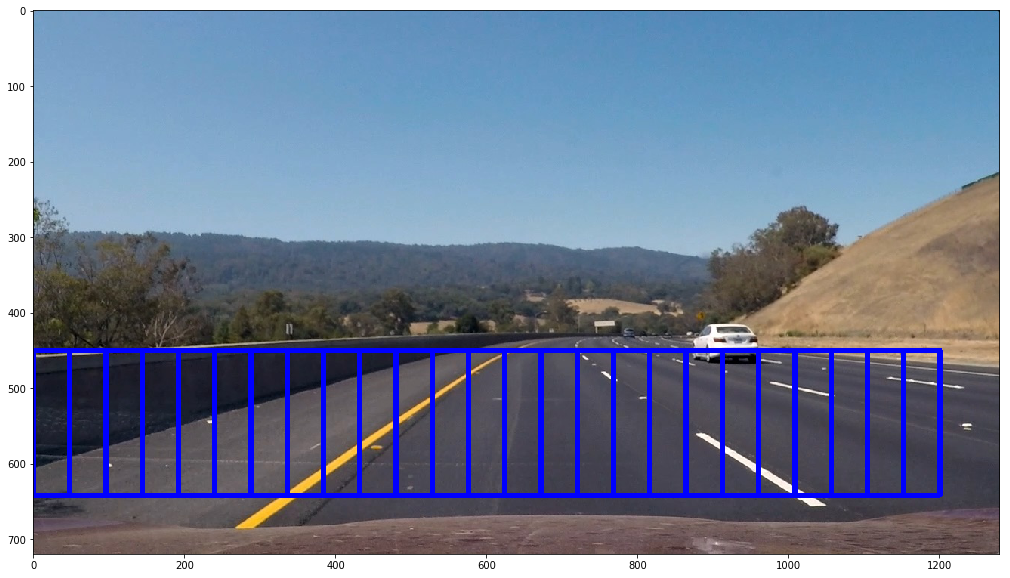

In [32]:
img = mpimg.imread('test_images/test3.jpg')
out_img = find_cars_debug(img,
                          ystart=450,
                          ystop=720,
                          scale=3,
                          cells_per_step=2)
plt.figure(figsize=(20,10))
plt.imshow(out_img)

In [33]:
params =[
         {'ystart': 400, 'ystop':530, 'scale': 1, 'cells_per_step': 2},
         {'ystart': 400, 'ystop':550, 'scale': 1.5, 'cells_per_step': 2}, #1 is good
         {'ystart': 450, 'ystop':650, 'scale': 2, 'cells_per_step': 2},
         {'ystart': 450, 'ystop':720, 'scale': 3, 'cells_per_step': 2},
        ]

In [37]:
img = mpimg.imread('test_images/test1.jpg')
bboxes = []
for param in params:
    ystart = param['ystart']
    ystop = param['ystop']
    scale = param['scale']
    cells_per_step = param['cells_per_step']
    bboxes += find_cars_bboxes(img,
                    ystart,
                    ystop,
                    scale,
                    svc,
                    X_scaler,
                    orient,
                    pix_per_cell,
                    cell_per_block,
                    cells_per_step,
                    spatial_size,
                    hist_bins,
                    color_space,
                    spatial_feat,
                    hist_feat,
                    hog_feat)

23


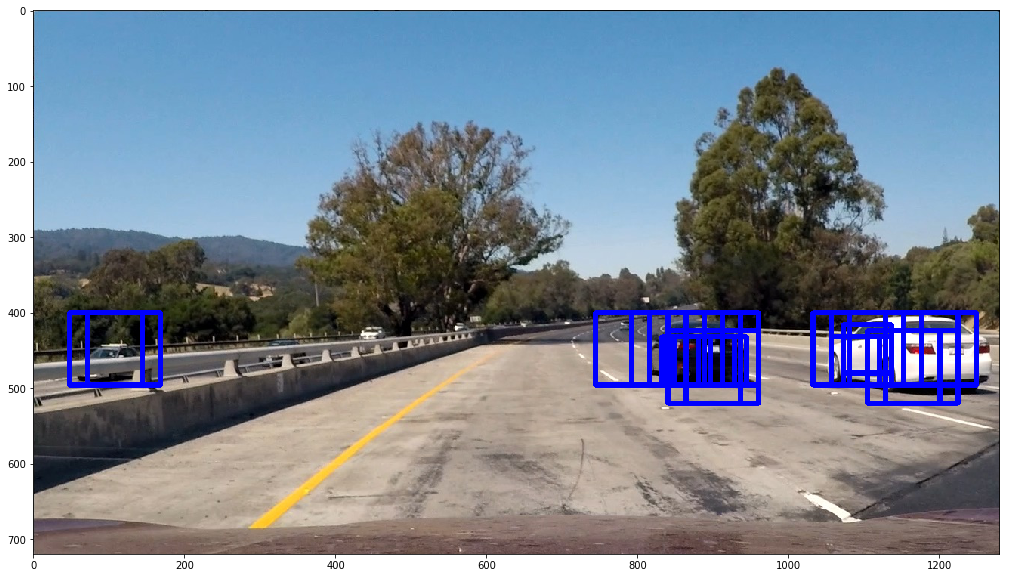

In [41]:
print(len(bboxes))
window_img = draw_boxes(img, bboxes, color=(0, 0, 255), thick=6)                    
plt.figure(figsize=(20,10))
plt.imshow(window_img)

In [42]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

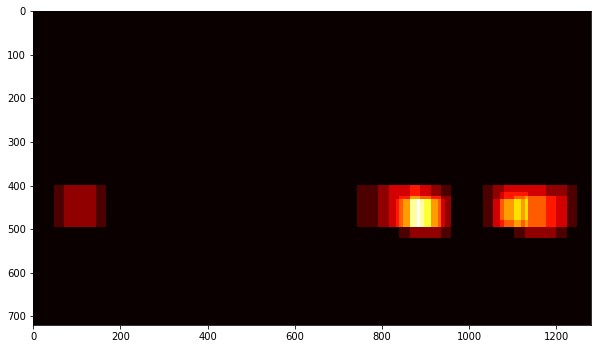

In [43]:
# Test out the heatmap
heatmap = np.zeros_like(window_img[:,:,0])
heatmap = add_heat(heatmap, bboxes)
plt.figure(figsize=(10,10))
plt.imshow(heatmap, cmap='hot')

In [44]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

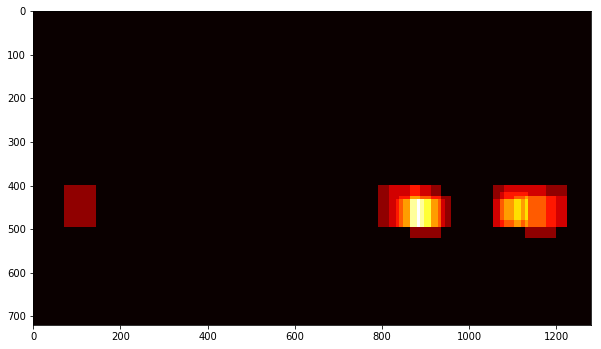

In [45]:
heatmap = apply_threshold(heatmap, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap, cmap='hot')

3 cars found


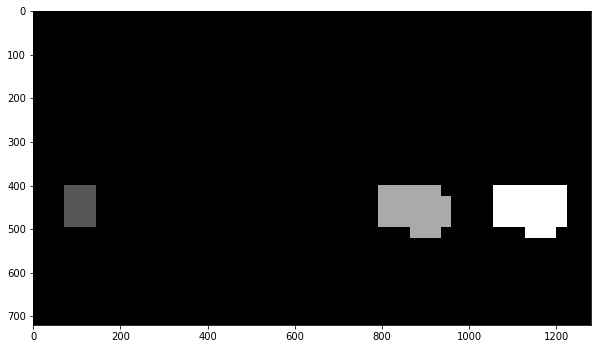

In [46]:
labels = label(heatmap)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

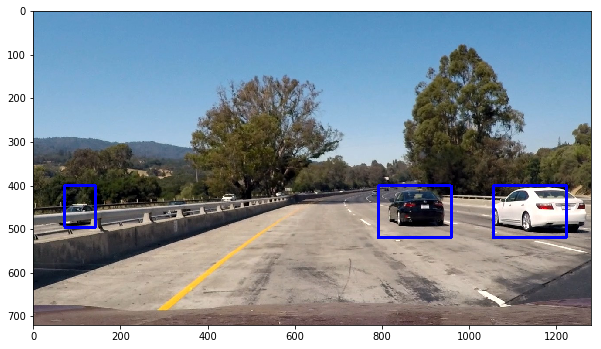

In [47]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

In [52]:
class VehicleDetector():
    def __init__(self, limit):
        self.history = []
        self.history_limit = limit
        
        
    def add_sample(self, bboxes):
        self.history.append(bboxes)
        if len(self.history) > self.history_limit:
            self.history = self.history[len(self.history) - self.history_limit:]
            
    def process_frame(self, img):
        bboxes = []
        for param in params:
            ystart = param['ystart']
            ystop = param['ystop']
            scale = param['scale']
            cells_per_step = param['cells_per_step']
            bboxes += find_cars_bboxes(img,
                                       ystart,
                                       ystop,
                                       scale,
                                       svc,
                                       X_scaler,
                                       orient,
                                       pix_per_cell,
                                       cell_per_block,
                                       cells_per_step,
                                       spatial_size,
                                       hist_bins,
                                       color_space,
                                       spatial_feat,
                                       hist_feat,
                                       hog_feat)

        if len(bboxes) > 0:
            self.add_sample(bboxes)


        heatmap_img = np.zeros_like(img[:,:,0])
        for bboxes in self.history:
            heatmap_img = add_heat(heatmap_img, bboxes)
        heatmap_img = apply_threshold(heatmap_img, max(3, 1 + len(self.history)//2))

        labels = label(heatmap_img)
        draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
        return draw_img

In [53]:
detector = VehicleDetector(15)

test_out_file = 'output_video/project_video.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(detector.process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


100%|█████████▉| 1260/1261 [15:24<00:00,  1.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 14min 57s, sys: 44.9 s, total: 15min 42s
Wall time: 15min 24s
